In [1]:
import os
import time

import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from matplotlib import gridspec

%matplotlib inline

print("Package is ready.")

Package is ready.


In [2]:
matplotlib.rcParams['figure.figsize'] = ((8/2.54)*2, (6/2.54)*2)
plt.rcParams["font.family"] = "arial"
plt.rcParams["font.serif"] = "arial"
plt.rcParams["mathtext.default"] = "rm"
plt.rcParams.update({'font.size': 12})
MARKER_SIZE = 15
cmap_m = ["#f4a6ad", "#f6957e", "#fccfa2", "#8de7be", "#86d6f2", "#24a9e4", "#b586e0", "#d7f293"]
cmap = ["#e94d5b", "#ef4d28", "#f9a54f", "#25b575", "#1bb1e7", "#1477a2", "#a662e5", "#c2f442"]

plt.rcParams['axes.linewidth'] = 2
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.width'] = 1

In [3]:
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

# Figure 2

### greenhouse environment

In [4]:
closed_env = pd.read_csv("./results/closed_data.csv", index_col="TIMESTAMP")
closed_env.index = pd.DatetimeIndex(closed_env.index)
closed_env = closed_env[["Pyrano_W", "GrnHsTemp(1)", "GrnHsHum(1)", "ECS(3)", "ECD(3)", "RWEC(3)", "MixTnkpH(3)", "RootTemp(1)"]]

In [5]:
open_env = pd.read_csv("./results/open_data.csv", index_col="TIMESTAMP")
open_env.index = pd.DatetimeIndex(open_env.index)
open_env = open_env[["GrnHsTemp(2)", "GrnHsHum(2)", "ECS(4)", "ECD(4)", "RWEC(4)", "MixTnkpH(4)", "RootTemp(2)"]]

In [6]:
env_df = pd.concat([closed_env, open_env], axis=1, sort=True)

In [7]:
env_df = env_df[~(env_df.index < '2018-01-12')]

In [8]:
#Dropping outlier
__ = env_df[["Pyrano_W"]].copy()
env_df = env_df[np.abs(env_df-env_df.mean())<=(3*env_df.std())]
env_df.loc["2018-01-21 11:50:00", "RootTemp(1)"] = pd.np.nan
env_df["Pyrano_W"] = __

In [9]:
__ = __.replace(0, np.NaN)
__.dropna(inplace=True)
__.index = (__.index).round("1d")
__ = __.groupby(__.index).mean()

In [10]:
# env_mean = env_df.rolling(1, win_type='triang').mean()
env_mean = env_df.copy()
env_mean.index = (env_mean.index).round("1d")#  - pd.Timedelta("10min")
env_mean = env_mean.groupby(env_mean.index).mean()
env_mean[["Pyrano_W"]] = __
# env_mean.loc["2017-11-17", "MixTnkpH(3)"] = 4
# env_mean.loc["2017-11-17", "RootTemp(1)"] = 22
env_mean.interpolate("linear", inplace=True)
# env_mean = env_mean[~(env_mean.index < '2017-12-22')]

In [11]:
fig2_shoot_closed = env_mean[["Pyrano_W", "GrnHsTemp(1)", "GrnHsHum(1)"]]
fig2_root_closed = env_mean[["ECS(3)", "ECD(3)", "RWEC(3)", "MixTnkpH(3)"]]

fig2_shoot_open = env_mean[["Pyrano_W", "GrnHsTemp(2)", "GrnHsHum(2)"]]
fig2_root_open = env_mean[["ECS(4)", "ECD(4)", "RWEC(4)", "MixTnkpH(4)"]]

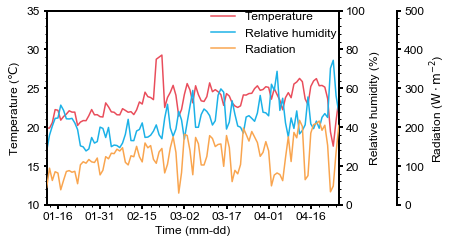

In [12]:
x_date = env_mean.index

fig = plt.figure(figsize=((8.5/2.54)*2, (6/2.54)*1.5))
ax0 = plt.subplot()
line_temp, = ax0.plot(x_date, fig2_shoot_closed[["GrnHsTemp(1)"]], c=cmap[0], label = "Temperature")

ax0.set_ylabel("Temperature ($℃$)")
ax0.set_ybound([10, 35])
ax0.yaxis.set_major_locator(MultipleLocator(5))
ax0.yaxis.set_minor_locator(MultipleLocator(1))

hum = ax0.twinx()
line_hum, = hum.plot(x_date, fig2_shoot_closed[["GrnHsHum(1)"]], c=cmap[4], label = "Relative humidity")
hum.set_ylabel("Relative humidity (%)")
hum.set_ybound([0, 100])
hum.yaxis.set_major_locator(MultipleLocator(20))
hum.yaxis.set_minor_locator(MultipleLocator(4))

rad = ax0.twinx()
line_rad, = rad.plot(x_date, fig2_shoot_closed[["Pyrano_W"]], c=cmap[2], label = "Radiation")
rad.set_ylabel("Radiation ($W \cdot m^{-2}$)")
rad.yaxis.set_major_locator(MultipleLocator(100))
rad.yaxis.set_minor_locator(MultipleLocator(20))
rad.spines["right"].set_position(("axes", 1.2))
make_patch_spines_invisible(rad)
rad.spines["right"].set_visible(True)

fig.legend(handles=[line_temp, line_hum, line_rad], 
           labels = ["Temperature", "Relative humidity", "Radiation"],
           frameon=False, bbox_to_anchor=(0.72, 0.95))
plt.axis([pd.Timestamp("2018-01-12"), pd.Timestamp("2018-04-26"), 0, 500])

ax0.set_xlabel("Time (mm-dd)")

rad.xaxis.set_major_locator(MultipleLocator(15))
rad.xaxis.set_minor_locator(MultipleLocator(3))
rad.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

fig.tight_layout()

fig.savefig("./figures/Fig02.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 4

### plant growth data

In [13]:
growth_df = pd.read_excel("../data/SW_Ion/Plant_grwoth.xlsx", index_col="Date")

In [14]:
growth_df.columns =['3_Height', '3_Diameter', '3_SPAD_up', '3_SPAD_up', '3_SPAD_up',
                    '3_SPAD_down', '3_SPAD_down', '3_SPAD_down', '3_n_Node',
                    '4_Height', '4_Diameter', '4_SPAD_up', '4_SPAD_up', '4_SPAD_up',
                    '4_SPAD_down', '4_SPAD_down', '4_SPAD_down', '4_n_Node']

In [15]:
growth_df = growth_df[~(growth_df.index < '2018-01-12')]

In [16]:
growth_df = growth_df.groupby(growth_df.columns, axis=1).mean()

In [17]:
growth_er_df = growth_df.groupby(growth_df.index).sem()
growth_df = growth_df.groupby(growth_df.index).mean()
growth_df.index = pd.DatetimeIndex(growth_df.index) + pd.Timedelta("12h")

In [18]:
growth_er_df

,3_Diameter,3_Height,3_SPAD_down,3_SPAD_up,3_n_Node,4_Diameter,4_Height,4_SPAD_down,4_SPAD_up,4_n_Node
Date,,,,,,,,,,
2018-01-17,0.490510,5.085273,2.056302,0.902933,0.734847,0.421900,3.492850,1.313181,0.990196,0.927362
2018-01-24,0.438178,4.641121,2.142911,1.067968,0.632456,0.355809,3.120897,1.678260,1.190079,0.734847
2018-01-31,0.241661,4.791659,2.437476,0.778860,0.374166,0.354119,3.000000,1.395970,2.052413,0.374166
2018-02-07,0.439773,4.641121,1.539466,1.220728,0.489898,0.351568,1.974842,2.474461,2.143761,0.374166
2018-02-14,0.426146,4.489989,1.029477,1.458896,0.316228,0.312090,2.167948,1.616945,1.893310,0.447214
2018-02-21,0.384708,4.478839,2.100857,0.993233,0.600000,0.473709,2.310844,1.292182,2.366305,0.489898
2018-03-02,0.410366,4.342810,1.080000,1.142171,0.509902,0.324962,2.154066,1.182248,1.947688,0.374166
2018-03-07,0.438862,4.296510,1.654052,1.988646,0.678233,0.334664,2.956349,2.283209,1.138059,0.734847
2018-03-14,0.269072,4.400000,0.887105,0.948180,0.812404,0.411582,3.733631,1.125483,0.879987,0.707107


In [68]:
growth_df.max()

3_Diameter      15.900000
3_Height       206.000000
3_SPAD_down     53.646667
3_SPAD_up       62.766667
3_n_Node        37.600000
4_Diameter      17.260000
4_Height       211.000000
4_SPAD_down     60.693333
4_SPAD_up       64.080000
4_n_Node        38.400000
dtype: float64

In [69]:
growth_df.min()

3_Diameter      14.800000
3_Height       156.400000
3_SPAD_down     50.033333
3_SPAD_up       54.720000
3_n_Node        25.800000
4_Diameter      15.700000
4_Height       169.000000
4_SPAD_down     56.300000
4_SPAD_up       55.880000
4_n_Node        26.400000
dtype: float64

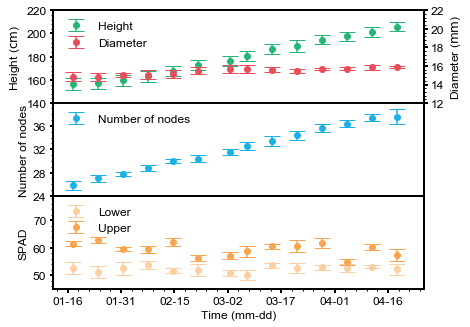

In [19]:
gs = gridspec.GridSpec(3, 1) 
fig = plt.figure(figsize=((8.5/2.54)*2, (6/2.54)*2))


origin = plt.subplot(gs[0])
height_closed = origin.errorbar(growth_df.index, growth_df.iloc[:, 1], growth_er_df.iloc[:, 1],
                                linestyle='None', marker='o', capsize=8, elinewidth=1.5, color=cmap[3])
# height_open = origin.errorbar(growth_df.index, growth_df.iloc[:, 6], growth_er_df.iloc[:, 6],
#                               linestyle='None', marker='o', fillstyle="none", capsize=8, elinewidth=1.5, color=cmap[3])

origin.set_ylabel("Height ($cm$)")
origin.set_ybound([140, 220])
origin.yaxis.set_major_locator(MultipleLocator(20))
origin.yaxis.set_minor_locator(MultipleLocator(4))

diameter = origin.twinx()
diameter_closed = diameter.errorbar(growth_df.index, growth_df.iloc[:, 0], growth_er_df.iloc[:, 0],
                                linestyle='None', marker='o', capsize=8, elinewidth=1.5, color=cmap[0], zorder=5)
# diameter_open = diameter.errorbar(growth_df.index, growth_df.iloc[:, 5], growth_er_df.iloc[:, 5],
#                               linestyle='None', marker='o', fillstyle="none", capsize=8, elinewidth=1.5, color=cmap[0], zorder=5)

diameter.set_ylabel("Diameter ($mm$)")
diameter.set_ybound([12, 22])

diameter.yaxis.set_major_locator(MultipleLocator(2))
diameter.yaxis.set_minor_locator(MultipleLocator(0.4))

origin.legend(handles=[height_closed, diameter_closed],
           labels = ["Height", "Diameter"],
           frameon=False, loc=0)
#plt.axis([x_date[0],x_date[-1], 0, 500])
plt.setp(origin.get_xticklabels(), visible=False)
origin.tick_params(bottom=False, top=False, labelbottom=False)




origin1 = plt.subplot(gs[1])

n_node_closed = origin1.errorbar(growth_df.index, growth_df.iloc[:, 4], growth_er_df.iloc[:, 4],
                                linestyle='None', marker='o', capsize=8, elinewidth=1.5, color=cmap[4], zorder=3)
# n_node_open = origin1.errorbar(growth_df.index, growth_df.iloc[:, 9], growth_er_df.iloc[:, 9],
#                               linestyle='None', marker='o', fillstyle="none", capsize=8, elinewidth=1.5, color=cmap[4], zorder=3)

origin1.set_ylabel("Number of nodes")
origin1.set_ybound([24, 39.9])
origin1.yaxis.set_major_locator(MultipleLocator(4))
origin1.yaxis.set_minor_locator(MultipleLocator(1))

origin1.legend(handles=[n_node_closed], labels = ["Number of nodes"],
           frameon=False, loc=0)
#plt.axis([x_date[0],x_date[-1], 0, 500])
plt.setp(origin1.get_xticklabels(), visible=False)
origin1.tick_params(bottom=False, top=False, labelbottom=False)




origin2 = plt.subplot(gs[2])
spad_down_closed = origin2.errorbar(growth_df.index, growth_df.iloc[:, 2], growth_er_df.iloc[:, 2],
                                linestyle='None', marker='o', capsize=8, elinewidth=1.5, color=cmap_m[2])
# spad_down_open = origin2.errorbar(growth_df.index, growth_df.iloc[:, 7], growth_er_df.iloc[:, 7],
#                               linestyle='None', marker='o', fillstyle="none", capsize=8, elinewidth=1.5, color=cmap_m[2])
spad_up_closed = origin2.errorbar(growth_df.index, growth_df.iloc[:, 3], growth_er_df.iloc[:, 3],
                                linestyle='None', marker='o', capsize=8, elinewidth=1.5, color=cmap[2])
# spad_up_open = origin2.errorbar(growth_df.index, growth_df.iloc[:, 8], growth_er_df.iloc[:, 8],
#                               linestyle='None', marker='o', fillstyle="none", capsize=8, elinewidth=1.5, color=cmap[2])
origin2.set_ylabel("SPAD")
origin2.set_ybound([45, 78.84])
origin2.legend(handles=[spad_down_closed, spad_up_closed],
           labels = ["Lower", "Upper"],
           frameon=False, loc=2)

origin2.yaxis.set_major_locator(MultipleLocator(10))
origin2.yaxis.set_minor_locator(MultipleLocator(2))

origin2.xaxis.set_major_locator(MultipleLocator(15))
origin2.xaxis.set_minor_locator(MultipleLocator(3))

origin.set_xbound(pd.Timestamp("2018-01-12"), pd.Timestamp("2018-04-26"))
origin1.set_xbound(pd.Timestamp("2018-01-12"), pd.Timestamp("2018-04-26"))
origin2.set_xbound(pd.Timestamp("2018-01-12"), pd.Timestamp("2018-04-26"))
origin2.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
origin2.set_xlabel("Time (mm-dd)")

fig.tight_layout()
plt.subplots_adjust(hspace=.0)
fig.savefig("./figures/Fig04.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 5

### EC & pH

In [20]:
manual_ECpH_df = pd.read_excel("../data/SW_Ion/manual_ECnpH.xlsx", index_col="Date")
manual_ECpH_df = manual_ECpH_df.reindex(env_mean.index)
manual_ECpH_df = manual_ECpH_df[["Water pH","3_EC","3_pH","4_EC","4_pH"]]

In [21]:
manual_ECpH_df = manual_ECpH_df.interpolate()

In [22]:
env_mean.loc["2018-02-15":"2018-03-21", "MixTnkpH(4)"].update(manual_ECpH_df.loc["2018-02-15":"2018-03-21", "4_pH"])

In [23]:
manual_ECpH_df.index = pd.DatetimeIndex(manual_ECpH_df.index) + pd.Timedelta("16h")

In [24]:
manual_ECpH_df.loc[pd.Timestamp("2018-04-05 16:00:00")] = np.nan

In [62]:
env_mean[["RWEC(3)"]].max()

RWEC(3)    3.611667
dtype: float64

In [63]:
env_mean[["RWEC(3)"]].min()

RWEC(3)    2.570304
dtype: float64

In [64]:
env_mean[["MixTnkpH(3)"]].max()

MixTnkpH(3)    7.951263
dtype: float64

In [65]:
env_mean[["MixTnkpH(3)"]].min()

MixTnkpH(3)    3.358994
dtype: float64

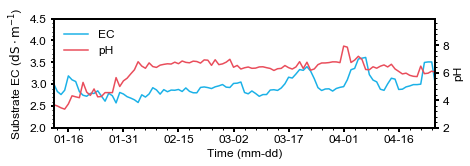

In [25]:
x_date = env_mean.index

fig = plt.figure(figsize=((8.5/2.54)*2, (6/2.54)))
ax0 = plt.subplot()
line_closed_ec, = ax0.plot(x_date, env_mean[["RWEC(3)"]], c=cmap[4], label = "EC Closed")

ax0.set_ylabel("Substrate EC ($dS\cdot m^{-1}$)")
ax0.set_ybound([2, 4.5])

ax1 = ax0.twinx()
line_closed_ph, = ax1.plot(x_date, env_mean[["MixTnkpH(3)"]], c=cmap[0], label = "pH Closed")
ax1.set_ylabel("pH")
ax1.set_ybound([2, 9.95])

ax0.legend(handles=[line_closed_ec, line_closed_ph], 
           labels = ["EC", "pH"],
           frameon=False, loc=2)

ax0.set_xbound(pd.Timestamp("2018-01-12"), pd.Timestamp("2018-04-26"))
ax1.set_xbound(pd.Timestamp("2018-01-12"), pd.Timestamp("2018-04-26"))
ax0.set_xlabel("Time (mm-dd)")

ax1.xaxis.set_major_locator(MultipleLocator(15))
ax1.xaxis.set_minor_locator(MultipleLocator(3))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

ax0.yaxis.set_major_locator(MultipleLocator(0.5))
ax0.yaxis.set_minor_locator(MultipleLocator(0.1))
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.yaxis.set_minor_locator(MultipleLocator(0.4))

fig.tight_layout()
plt.subplots_adjust(hspace=.0)

fig.savefig("./figures/Fig05.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 6

In [71]:
ions_df = pd.read_excel("../data/SW_Ion/Ion concentration_meq_20171109-20180426.xlsx", skiprows=1, index_col="date")
ions_df.drop([columns for columns in ions_df.columns if "Unnamed:" in columns], axis= 1, inplace=True)
ions_df.drop([columns for columns in ions_df.columns if ".2" in columns], axis= 1, inplace=True)
ions_df.drop([columns for columns in ions_df.columns if ".3" in columns], axis= 1, inplace=True)
ions_df = ions_df[~(ions_df.index < '2018-01-12')]

In [73]:
ions_df.min()

K        2.223907
Ca      16.443363
Mg       5.265419
S        4.075234
N       21.117874
P        0.127527
K.1      8.942460
Ca.1    15.838872
Mg.1     0.893808
S.1      0.234934
N.1     24.745505
P.1      0.015820
dtype: float64

In [74]:
ions_df.max()

K       10.893261
Ca      46.638723
Mg      17.122979
S       19.692327
N       52.094657
P        2.140099
K.1     15.852761
Ca.1    40.116467
Mg.1    14.689981
S.1     15.499314
N.1     57.939678
P.1      3.453273
dtype: float64

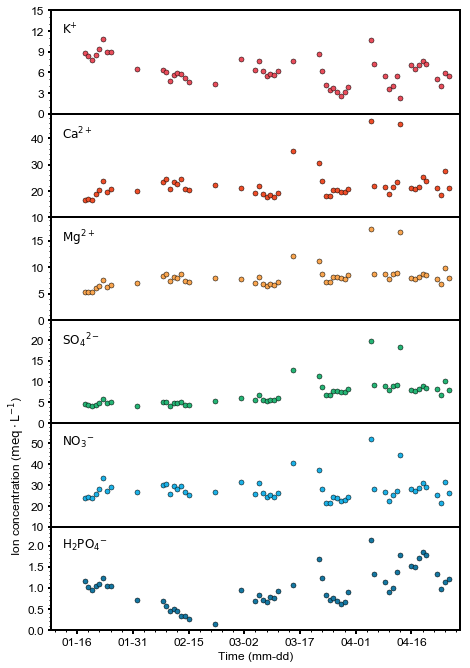

In [27]:
x_date = ions_df.index
leg = []

gs = gridspec.GridSpec(6, 1) 
fig = plt.figure(figsize=((8.5/2.54)*2, (6/2.54)*4))

i = 0
ax0 = plt.subplot(gs[i])
ax0.plot(x_date, ions_df.iloc[:, i], "o",
        markersize=MARKER_SIZE/3, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])
ax0.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax0.set_ybound([0,15])
ax0.yaxis.set_major_locator(MultipleLocator(3))
ax0.yaxis.set_minor_locator(MultipleLocator(1))
plt.setp(ax0.get_xticklabels(), visible=False)
ax0.tick_params(bottom=False, top=False, labelbottom=False)
ax0.legend(["$K^{+}$"], loc=2, frameon=False,
           markerfirst=False, markerscale=0)


i = 1
ax1 = plt.subplot(gs[i])
ax1.plot(x_date, ions_df.iloc[:, i], "o",
        markersize=MARKER_SIZE/3, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax1.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax1.set_ybound([10,49.5])
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(2))
plt.setp(ax1.get_xticklabels(), visible=False)
ax1.tick_params(bottom=False, top=False, labelbottom=False)
ax1.legend(["$Ca^{2+}$"], loc=2, frameon=False,
           markerfirst=False, markerscale=0)


i = 2
ax2 = plt.subplot(gs[i])
ax2.plot(x_date, ions_df.iloc[:, i], "o",
        markersize=MARKER_SIZE/3, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax2.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax2.set_ybound([0,19.5])
ax2.yaxis.set_major_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(1))
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.tick_params(bottom=False, top=False, labelbottom=False)
ax2.legend(["$Mg^{2+}$"], loc=2, frameon=False,
           markerfirst=False, markerscale=0)


i = 3
ax3 = plt.subplot(gs[i])
ax3.plot(x_date, ions_df.iloc[:, i], "o",
        markersize=MARKER_SIZE/3, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax3.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax3.set_ybound([0,24.7])
ax3.yaxis.set_major_locator(MultipleLocator(5))
ax3.yaxis.set_minor_locator(MultipleLocator(1))
plt.setp(ax3.get_xticklabels(), visible=False)
ax3.tick_params(bottom=False, top=False, labelbottom=False)
ax3.legend(["${SO_{4}}^{2-}$"], loc=2, frameon=False,
           markerfirst=False, markerscale=0)


i = 4
ax4 = plt.subplot(gs[i])
ax4.plot(x_date, ions_df.iloc[:, i], "o",
        markersize=MARKER_SIZE/3, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax4.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax4.set_ybound([10,59.7])
ax4.yaxis.set_major_locator(MultipleLocator(10))
ax4.yaxis.set_minor_locator(MultipleLocator(2))
ax4.set_ylabel("Ion concentration ($meq \cdot L^{-1}$)")
plt.setp(ax4.get_xticklabels(), visible=False)
ax4.tick_params(bottom=False, top=False, labelbottom=False)
ax4.legend(["${NO_{3}}^{-}$"], loc=2, frameon=False,
           markerfirst=False, markerscale=0)


i = 5
ax5 = plt.subplot(gs[i])
ax5.plot(x_date, ions_df.iloc[:, i], "o",
        markersize=MARKER_SIZE/3, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax5.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax5.set_ybound([0, 2.45])
ax5.yaxis.set_major_locator(MultipleLocator(0.5))
ax5.yaxis.set_minor_locator(MultipleLocator(0.1))
ax5.legend(["${H_{2}PO_{4}}^{-}$"], loc=2, frameon=False,
           markerfirst=False, markerscale=0)
ax5.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax5.xaxis.set_major_locator(MultipleLocator(15))
ax5.xaxis.set_minor_locator(MultipleLocator(3))
ax5.set_xlabel("Time (mm-dd)")


fig.tight_layout()
plt.subplots_adjust(hspace=.0)
fig.savefig("./figures/Fig06.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 7&9a&11a

### 1:1 & regerssion line (Closed)

In [28]:
pred_results = []
for i in range(5):
    pred_results.append(pd.read_csv("./results/results_Ion_closed_altMT_LN_I1h_T168_F" + str(i+1) + ".csv", index_col="date"))
pred_result = pd.concat(pred_results)
pred_result = pred_result.sort_index()
pred_result = pred_result[~pred_result.index.duplicated()]
pred_result.index = pd.DatetimeIndex(pred_result.index)

In [29]:
pred_result.drop([pd.Timestamp("2018-04-13 16:00:00")], inplace=True)

In [30]:
r2_score(pred_result.iloc[:, :6], pred_result.iloc[:, 6:])

0.6698453362425344

In [31]:
np.mean(np.sqrt(mean_squared_error(pred_result.iloc[:, :6], pred_result.iloc[:, 6:], multioutput="raw_values")))

1.5803237760465272

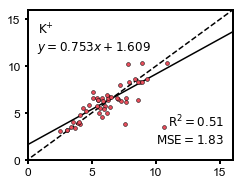

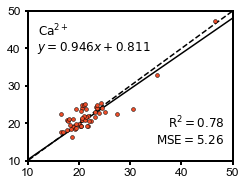

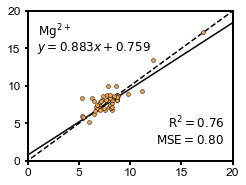

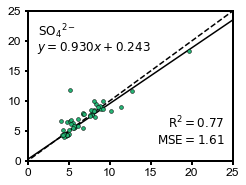

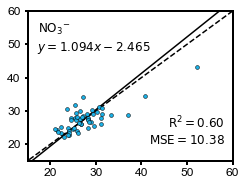

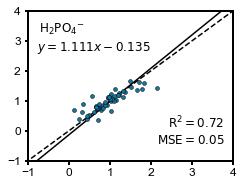

In [32]:
min_ = min(pred_result.min())
max_ = max(pred_result.max())
axis = [[0, 16]*2,
        [10, 50]*2,
        [0, 20]*2,
        [0, 25]*2,
        [15, 60]*2,
        [-1, 4]*2,
       ]
labels = ["$K^{+}$", "$Ca^{2+}$", "$Mg^{2+}$", "${SO_{4}}^{2-}$", "${NO_{3}}^{-}$", "${H_{2}PO_{4}}^{-}$"]

for _ in range(6):
    Y, X = pred_result.iloc[:, _].values.reshape(-1, 1), pred_result.iloc[:, _+6].values.reshape(-1, 1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    Yp = regr.predict(X)
    reg_x = np.arange(pred_result.iloc[:, _].min() - 10, pred_result.iloc[:, _].max() + 10).reshape(-1,1)
    reg_y = reg_x*regr.coef_ + regr.intercept_
    
    fig = plt.figure(figsize = ((8/2.54)*(7/6), (6/2.54)*(7/6)))
    ax = plt.subplot()
    x_linear = np.arange(pred_result.iloc[:, _].min() - 10, pred_result.iloc[:, _].max() + 10)
    y_linear = x_linear
    
    reg_line = ax.plot(reg_x, reg_y, "k-", label = pred_result.columns[_+6] + "line", zorder=7)
    linear = ax.plot(x_linear, y_linear, "k--", label = pred_result.columns[_+6] + "line", zorder=5)
    scatter = ax.scatter(pred_result.iloc[:, _], pred_result.iloc[:, _+6], edgecolor='black', linewidth=0.5, 
                         s=MARKER_SIZE, c=cmap[_], label = labels[_], zorder=10)
    if regr.intercept_ < 0:
        ax.text(0.60, 0.70, '$\it{y = %.3fx%.3f}$' % (regr.coef_, regr.intercept_),
                verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    else:
        ax.text(0.60, 0.70, '$\it{y = %.3fx+%.3f}$' % (regr.coef_, regr.intercept_),
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.96, 0.1, '$R^{2} = %.2f$\n$MSE = %.2f$' % (r2_score(Y, Yp), mean_squared_error(Y, Yp)),
                verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)

    ax.legend(handles = [scatter], frameon = False, markerfirst=False, markerscale=0)
    #plt.xlabel("Measured " + pred_result.columns[_] + " concentration (meq)")
    #plt.ylabel("Estimated " + pred_result.columns[_] + " concentration (meq)")
    plt.axis(axis[_])
    fig.savefig("./figures/Fig07" + pred_result.columns[_] +".png", dpi=600, transparent=True, format="png")
    plt.show()

# Figure 9a

### Chronological arrangement (Closed)

In [33]:
CHRONOL_RANGE = pd.date_range(pred_result.index[0],  pred_result.index[-1], freq="1d")
chronol_result = pred_result.reindex(CHRONOL_RANGE)

In [34]:
x_date

DatetimeIndex(['2018-01-12', '2018-01-13', '2018-01-14', '2018-01-15',
               '2018-01-16', '2018-01-17', '2018-01-18', '2018-01-19',
               '2018-01-20', '2018-01-21',
               ...
               '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20',
               '2018-04-21', '2018-04-22', '2018-04-23', '2018-04-24',
               '2018-04-25', '2018-04-26'],
              dtype='datetime64[ns]', name='date', length=105, freq=None)

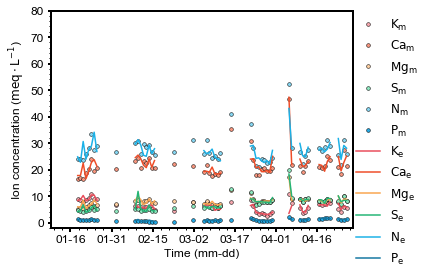

In [35]:
x_date = CHRONOL_RANGE
fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*1.7))
ax = plt.subplot()
for i in range(6):
    ax.plot(x_date, chronol_result.iloc[:, i], "o", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap_m[i])
for i in range(6):
    ax.plot(x_date, chronol_result.iloc[:, i+6], "-", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax.set_xlabel("Time (mm-dd)")
ax.set_ylabel("Ion concentration ($meq \cdot L^{-1}$)")
ax.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax.set_ybound([-2,80])
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.legend(["$K_m$", "$Ca_m$", "$Mg_m$", "$S_m$", "$N_m$", "$P_m$", "$K_e$", "$Ca_e$", "$Mg_e$", "$S_e$", "$N_e$", "$P_e$"],
          frameon=False, bbox_to_anchor=(1.25, 1.02))

fig.tight_layout()
fig.savefig("./figures/Fig09a.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 10a

### Interpolated result (Closed)

In [36]:
interpol_result = []
for i in range(5):
    interpol_result.append(pd.read_csv("./results/results_ion_LSTM_closed_interpolate_F" + str(i+1) + ".csv", index_col="date"))

In [37]:
temp_l = []
interpol_result = pd.concat(interpol_result, axis=1)
for col in interpol_result.columns[:6]:
    temp_l.append(pd.DataFrame((interpol_result[col].sum(axis=1)
                                - interpol_result[col].max(axis=1)
                                - interpol_result[col].min(axis=1))/3,
                               columns=[col]))
interpol_result = pd.concat(temp_l, axis=1)

In [38]:
interpol_result.index = pd.DatetimeIndex(interpol_result.index)
INTERPOL_RANGE = pd.date_range("2018-01-12 16:00:00",  "2018-04-26 16:00:00", freq="1d")
interpol_result.index += pd.Timedelta("16h")
interpol_result = interpol_result.reindex(INTERPOL_RANGE)
interpol_label = chronol_result.iloc[:, :6]
interpol_label = interpol_label.reindex(INTERPOL_RANGE)
# interpol_label = interpol_label.fillna(interpol_result)

tmp = chronol_result.iloc[:, 6:]
tmp.columns = ["K", "Ca", "Mg", "S", "N", "P"]
interpol_result = interpol_result.fillna(tmp)

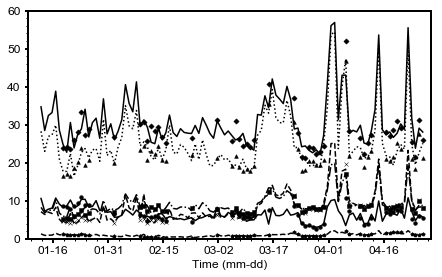

In [39]:
x_date = INTERPOL_RANGE
fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*1.7))
ax = plt.subplot()

i=0
ax.plot(x_date, interpol_label.iloc[:, i], "o", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
ax.plot(x_date, interpol_result.iloc[:, i], "-", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
i=1
ax.plot(x_date, interpol_label.iloc[:, i], "^", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
ax.plot(x_date, interpol_result.iloc[:, i], ":", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
i=2
ax.plot(x_date, interpol_label.iloc[:, i], "s", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
ax.plot(x_date, interpol_result.iloc[:, i], "-.", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
i=3
ax.plot(x_date, interpol_label.iloc[:, i], "x", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
ax.plot(x_date, interpol_result.iloc[:, i], "--", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
i=4
ax.plot(x_date, interpol_label.iloc[:, i], "D", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
ax.plot(x_date, interpol_result.iloc[:, i], "-", 
        markersize=MARKER_SIZE/4, markeredgecolor='gray', markeredgewidth =0.5, c="k")
i=5
ax.plot(x_date, interpol_label.iloc[:, i], "p", 
        markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c="k")
ax.plot(x_date, interpol_result.iloc[:, i], "--", 
        markersize=MARKER_SIZE/4, markeredgecolor='gray', markeredgewidth =0.5, c="k")


ax.set_xlabel("Time (mm-dd)")
#ax.set_ylabel("Ion concentration ($meq \cdot L^{-1}$)")
ax.set_ybound([0,60])
ax.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
# ax.legend(["$K^{+}_{m}$", "$Ca^{2+}_{m}$", "$Mg^{2+}_{m}$", "${SO_{4}}^{2-}_{m}$", "${NO_{3}}^{-}_{m}$", "${H_{2}PO_{4}}^{-}_{m}$",
#            "$K^{+}_{e}$", "$Ca^{2+}_{e}$", "$Mg^{2+}_{e}$", "${SO_{4}}^{2-}_{e}$", "${NO_{3}}^{-}_{e}$", "${H_{2}PO_{4}}^{-}_{e}$"],
#           frameon=False, bbox_to_anchor=(1.0, 1.02))

fig.tight_layout()
fig.savefig("./figures/Fig10a.png", dpi=600, transparent=True, format="png")
plt.show()

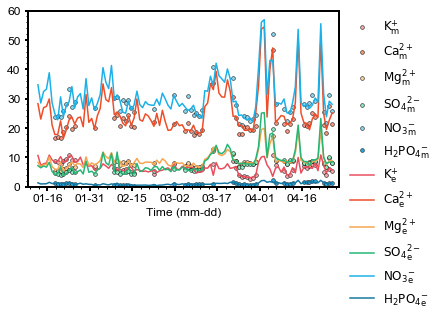

In [40]:
x_date = INTERPOL_RANGE
fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*1.7))
ax = plt.subplot()

for i in range(6):
    ax.plot(x_date, interpol_label.iloc[:, i], "o", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap_m[i])
for i in range(6):
    ax.plot(x_date, interpol_result.iloc[:, i], "-", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax.set_xlabel("Time (mm-dd)")
#ax.set_ylabel("Ion concentration ($meq \cdot L^{-1}$)")
ax.set_ybound([0,60])
ax.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.legend(["$K^{+}_{m}$", "$Ca^{2+}_{m}$", "$Mg^{2+}_{m}$", "${SO_{4}}^{2-}_{m}$", "${NO_{3}}^{-}_{m}$", "${H_{2}PO_{4}}^{-}_{m}$",
           "$K^{+}_{e}$", "$Ca^{2+}_{e}$", "$Mg^{2+}_{e}$", "${SO_{4}}^{2-}_{e}$", "${NO_{3}}^{-}_{e}$", "${H_{2}PO_{4}}^{-}_{e}$"],
          frameon=False, bbox_to_anchor=(1.0, 1.02))

fig.tight_layout()
fig.savefig("./figures/Fig10a.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 11a

In [41]:
total_ion_result = interpol_result.sum(axis=1, skipna=True).replace(0, pd.np.nan)
total_ion_label = interpol_label.sum(axis=1, skipna=True).replace(0, pd.np.nan)

In [42]:
ratio_result = interpol_result.divide(total_ion_result, axis=0)
ratio_label = interpol_label.divide(total_ion_label, axis=0)

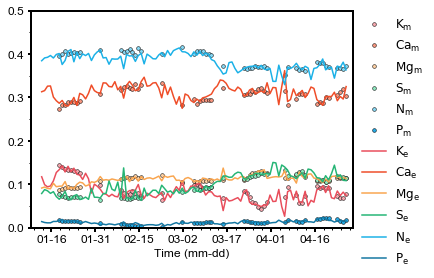

In [43]:
x_date = INTERPOL_RANGE
fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*1.7))
ax = plt.subplot()

for i in range(6):
    ax.plot(x_date, ratio_label.iloc[:, i], "o", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap_m[i])
for i in range(6):
    ax.plot(x_date, ratio_result.iloc[:, i], "-", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax.set_xlabel("Time (mm-dd)")
#ax.set_ylabel("Ratio of ion")
ax.set_ybound([0, 0.5])
ax.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.legend(["$K_m$", "$Ca_m$", "$Mg_m$", "$S_m$", "$N_m$", "$P_m$", "$K_e$", "$Ca_e$", "$Mg_e$", "$S_e$", "$N_e$", "$P_e$"],
          frameon=False, bbox_to_anchor=(1.25, 1.02))

fig.tight_layout()
fig.savefig("./figures/Fig11a.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 8

### 1:1 & regerssion line (Open)

In [44]:
pred_results = []
for i in range(5):
    pred_results.append(pd.read_csv("./results/results_Ion_open_MT_LN_I1h_T168_F" + str(i+1) + ".csv", index_col="date"))
pred_result = pd.concat(pred_results)
pred_result = pred_result.sort_index()
pred_result = pred_result[~pred_result.index.duplicated()]
pred_result.index = pd.DatetimeIndex(pred_result.index)

In [45]:
pred_result.drop([pd.Timestamp("2018-04-13 16:00:00")], inplace=True)

In [46]:
r2_score(pred_result.iloc[:, :6], pred_result.iloc[:, 6:])

0.7437422372468978

In [47]:
np.mean(np.sqrt(mean_squared_error(pred_result.iloc[:, :6], pred_result.iloc[:, 6:], multioutput="raw_values")))

1.484096022511447

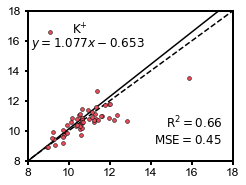

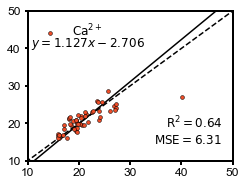

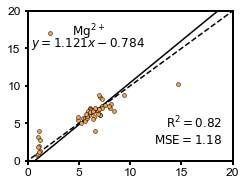

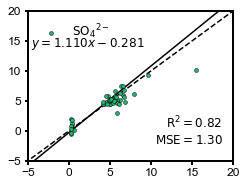

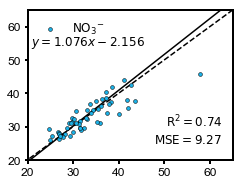

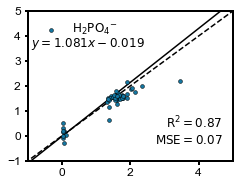

In [48]:
min_ = min(pred_result.min())
max_ = max(pred_result.max())
axis = [[8, 18]*2,
        [10, 50]*2,
        [0, 20]*2,
        [-5, 20]*2,
        [20, 65]*2,
        [-1, 5]*2,
       ]
labels = ["$K^{+}$", "$Ca^{2+}$", "$Mg^{2+}$", "${SO_{4}}^{2-}$", "${NO_{3}}^{-}$", "${H_{2}PO_{4}}^{-}$"]

for _ in range(6):
    Y, X = pred_result.iloc[:, _].values.reshape(-1, 1), pred_result.iloc[:, _+6].values.reshape(-1, 1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    Yp = regr.predict(X)
    reg_x = np.arange(pred_result.iloc[:, _].min() - 10, pred_result.iloc[:, _].max() + 10).reshape(-1,1)
    reg_y = reg_x*regr.coef_ + regr.intercept_
    
    fig = plt.figure(figsize = ((8/2.54)*(7/6), (6/2.54)*(7/6)))
    ax = plt.subplot()
    x_linear = np.arange(pred_result.iloc[:, _].min() - 10, pred_result.iloc[:, _].max() + 10)
    y_linear = x_linear
    
    reg_line = ax.plot(reg_x, reg_y, "k-", label = pred_result.columns[_] + "line", zorder=7)
    linear = ax.plot(x_linear, y_linear, "k--", label = pred_result.columns[_] + "line", zorder=5)
    scatter = ax.scatter(pred_result.iloc[:, _], pred_result.iloc[:, _+6], edgecolor='black', linewidth=0.5, 
                         s=MARKER_SIZE, c=cmap[_], label = labels[_], zorder=10)
    if regr.intercept_ < 0:
        ax.text(0.57, 0.73, '$\it{y = %.3fx%.3f}$' % (regr.coef_, regr.intercept_),
                verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    else:
        ax.text(0.57, 0.73, '$\it{y = %.3fx+%.3f}$' % (regr.coef_, regr.intercept_),
        verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    ax.text(0.95, 0.1, '$R^{2} = %.2f$\n$MSE = %.2f$' % (r2_score(Y, Yp), mean_squared_error(Y, Yp)),
                verticalalignment='bottom', horizontalalignment='right', transform=ax.transAxes)
    ax.legend(handles = [scatter], frameon = False)
    plt.axis(axis[_])
    fig.savefig("./figures/Fig08" + pred_result.columns[_] +".png", dpi=600, transparent=True, format="png")
    plt.show()

# Figure 9b

### Chronological arrangement (Open)

In [49]:
CHRONOL_RANGE = pd.date_range(pred_result.index[0],  pred_result.index[-1], freq="1d")
chronol_result = pred_result.reindex(CHRONOL_RANGE)

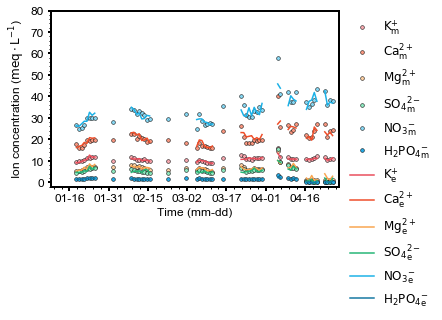

In [50]:
x_date = CHRONOL_RANGE
fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*1.7))
ax = plt.subplot()
for i in range(6):
    ax.plot(x_date, chronol_result.iloc[:, i], "o", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap_m[i])
for i in range(6):
    ax.plot(x_date, chronol_result.iloc[:, i+6], "-", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax.set_xlabel("Time (mm-dd)")
ax.set_ylabel("Ion concentration ($meq \cdot L^{-1}$)")
ax.set_ybound([-2,80])
ax.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.legend(["$K^{+}_{m}$", "$Ca^{2+}_{m}$", "$Mg^{2+}_{m}$", "${SO_{4}}^{2-}_{m}$", "${NO_{3}}^{-}_{m}$", "${H_{2}PO_{4}}^{-}_{m}$",
           "$K^{+}_{e}$", "$Ca^{2+}_{e}$", "$Mg^{2+}_{e}$", "${SO_{4}}^{2-}_{e}$", "${NO_{3}}^{-}_{e}$", "${H_{2}PO_{4}}^{-}_{e}$"],
          frameon=False, bbox_to_anchor=(1.0, 1.02))


fig.tight_layout()
fig.savefig("./figures/Fig09b.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 10b

### Interpolated result (Open)

In [51]:
interpol_result = []
for i in range(5):
    interpol_result.append(pd.read_csv("./results/results_ion_LSTM_open_interpolate_F" + str(i+1) + ".csv", index_col="date"))

In [52]:
temp_l = []
interpol_result = pd.concat(interpol_result, axis=1)
for col in interpol_result.columns[:6]:
    temp_l.append(pd.DataFrame((interpol_result[col].sum(axis=1)
                                - interpol_result[col].max(axis=1)
                                - interpol_result[col].min(axis=1))/3,
                               columns=[col]))
interpol_result = pd.concat(temp_l, axis=1)

In [53]:
interpol_result.index = pd.DatetimeIndex(interpol_result.index)
INTERPOL_RANGE = pd.date_range("2018-01-12 16:00:00",  "2018-04-26 16:00:00", freq="1d")
interpol_result.index += pd.Timedelta("16h")
interpol_result = interpol_result.reindex(INTERPOL_RANGE)
interpol_label = chronol_result.iloc[:, :6]
interpol_label.columns = interpol_result.columns
interpol_label = interpol_label.reindex(INTERPOL_RANGE)
#interpol_label = interpol_label.fillna(interpol_result)

tmp = chronol_result.iloc[:, 6:]
tmp.columns = ["K", "Ca", "Mg", "S", "N", "P"]
interpol_result = interpol_result.fillna(tmp)

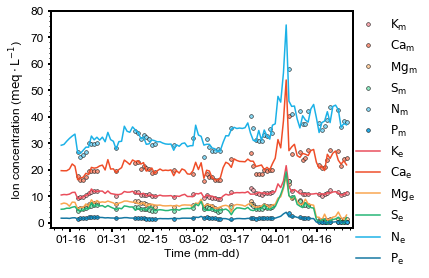

In [54]:
x_date = INTERPOL_RANGE
fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*1.7))
ax = plt.subplot()

for i in range(6):
    ax.plot(x_date, interpol_label.iloc[:, i], "o", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap_m[i])
for i in range(6):
    ax.plot(x_date, interpol_result.iloc[:, i], "-", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax.set_xlabel("Time (mm-dd)")
ax.set_ylabel("Ion concentration ($meq \cdot L^{-1}$)")
ax.set_ybound([-2,80])
ax.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))
ax.legend(["$K_m$", "$Ca_m$", "$Mg_m$", "$S_m$", "$N_m$", "$P_m$", "$K_e$", "$Ca_e$", "$Mg_e$", "$S_e$", "$N_e$", "$P_e$"],
          frameon=False, bbox_to_anchor=(1.25, 1.02))

fig.tight_layout()
fig.savefig("./figures/Fig10b.png", dpi=600, transparent=True, format="png")
plt.show()

# Figure 11b

In [55]:
total_ion_result = interpol_result.sum(axis=1, skipna=True).replace(0, pd.np.nan)
total_ion_label = interpol_label.sum(axis=1, skipna=True).replace(0, pd.np.nan)

In [56]:
ratio_result = interpol_result.divide(total_ion_result, axis=0)
ratio_label = interpol_label.divide(total_ion_label, axis=0)

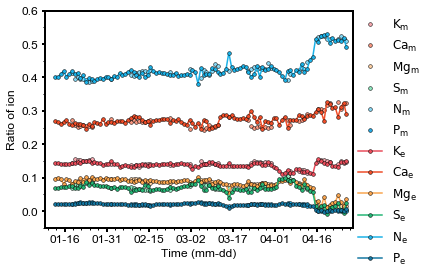

In [57]:
x_date = INTERPOL_RANGE
fig = plt.figure(figsize = ((8/2.54)*2, (6/2.54)*1.7))
ax = plt.subplot()

for i in range(6):
    ax.plot(x_date, ratio_label.iloc[:, i], "o", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap_m[i])
for i in range(6):
    ax.plot(x_date, ratio_result.iloc[:, i], "o-", 
            markersize=MARKER_SIZE/4, markeredgecolor='black', markeredgewidth =0.5, c=cmap[i])

ax.set_xlabel("Time (mm-dd)")
ax.set_ylabel("Ratio of ion")
ax.set_ybound([-0.05, 0.6])
ax.set_xbound(pd.Timestamp("2018-01-09"), pd.Timestamp("2018-04-29"))
ax.xaxis.set_major_locator(MultipleLocator(15))
ax.xaxis.set_minor_locator(MultipleLocator(3))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.legend(["$K_m$", "$Ca_m$", "$Mg_m$", "$S_m$", "$N_m$", "$P_m$", "$K_e$", "$Ca_e$", "$Mg_e$", "$S_e$", "$N_e$", "$P_e$"],
          frameon=False, bbox_to_anchor=(1.25, 1.02))

fig.tight_layout()
fig.savefig("./figures/Fig11b.png", dpi=600, transparent=True, format="png")
plt.show()

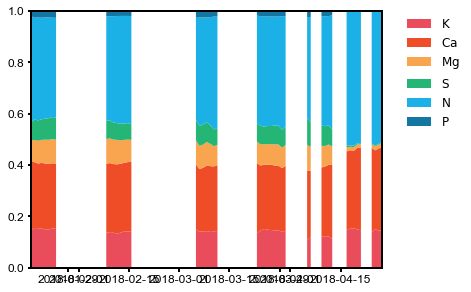

In [58]:
plt.stackplot(x_date,
              ratio_label.iloc[:, 0],
              ratio_label.iloc[:, 1],
              ratio_label.iloc[:, 2],
              ratio_label.iloc[:, 3],
              ratio_label.iloc[:, 4],
              ratio_label.iloc[:, 5],
              colors=cmap,
             )
plt.legend(["$K$", "$Ca$", "$Mg$", "$S$", "$N$", "$P$"],
          frameon=False, bbox_to_anchor=(1.25, 1.02))
plt.margins(0,0)